In [7]:
"""
Notebook Matrix Profile – ampiimts Python 3.11 package

Goal:
From pre processing signal with original value, normalize value, timestamp. 
We identify discord and motifs with a fix window on matrix profile methode (stumpy.maamp)
"""
import numpy as np
import pandas as pd
import ampiimts
import time
import os
import stumpy

In [8]:
#import files
folder = '../../dataset/pollution'
pds = []
with os.scandir(folder) as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith('csv'):
            # list of sensors with some parameters -> list[pd.DataFrame[timestamp, value1, value2, etc..., latitude, longitude]]) 
            pds.append(pd.read_csv(folder+'/'+entry.name))
len(pds)
pds = pds[:10]
# and not entry.name.startswith('pollutionData')

In [9]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=False)
# for df in pds_normalized:
#     print(df.isna().sum().sum())
# P, I = stumpy.mstump(pds_normalized[0], 2016)

mx_profile = ampiimts.matrix_profile(pds_normalized)
# ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
#                             time_index=matrix_profiles[0].index, 
#                             capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
#                             cmap="magma")  # Ou "viridis", "cubehelix", etc.

Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0))]
Most frequent window size after 3 runs (all dfs): 168h
coucou ça fonctionne


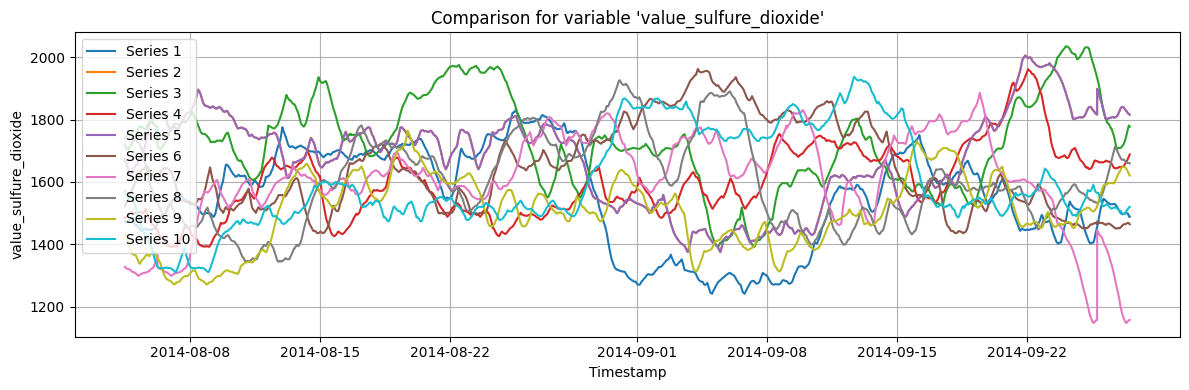

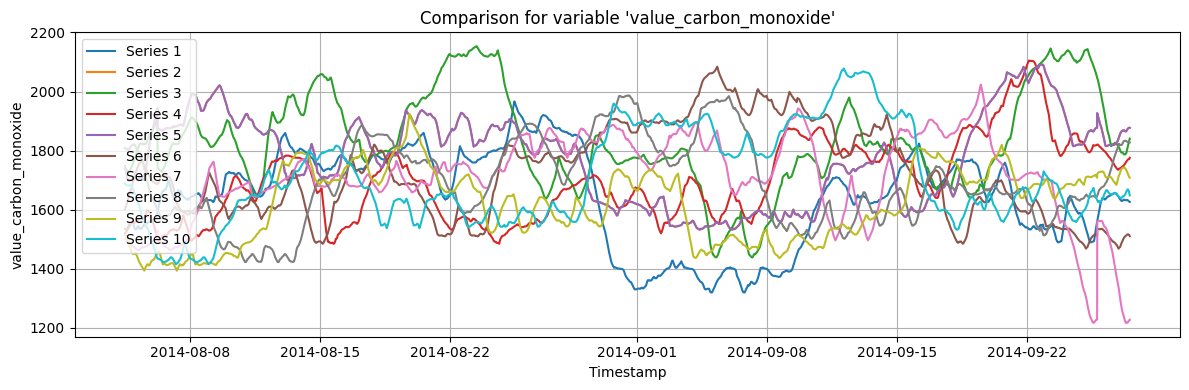

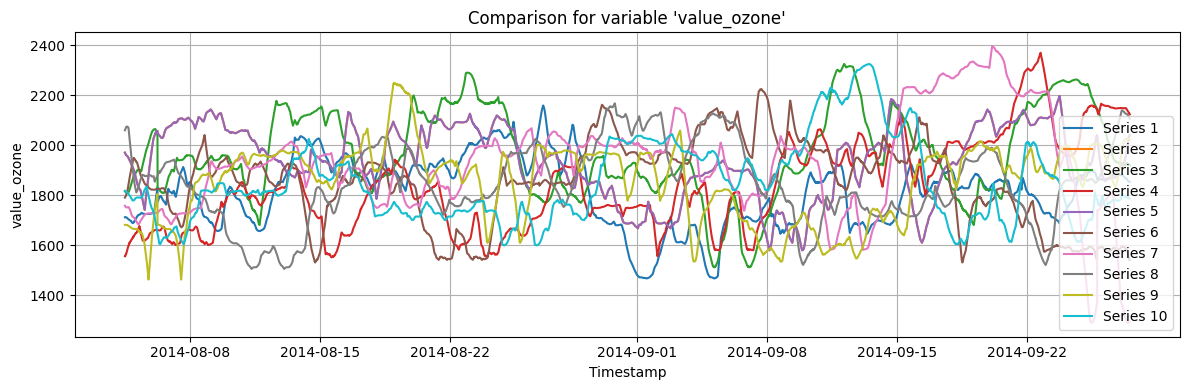

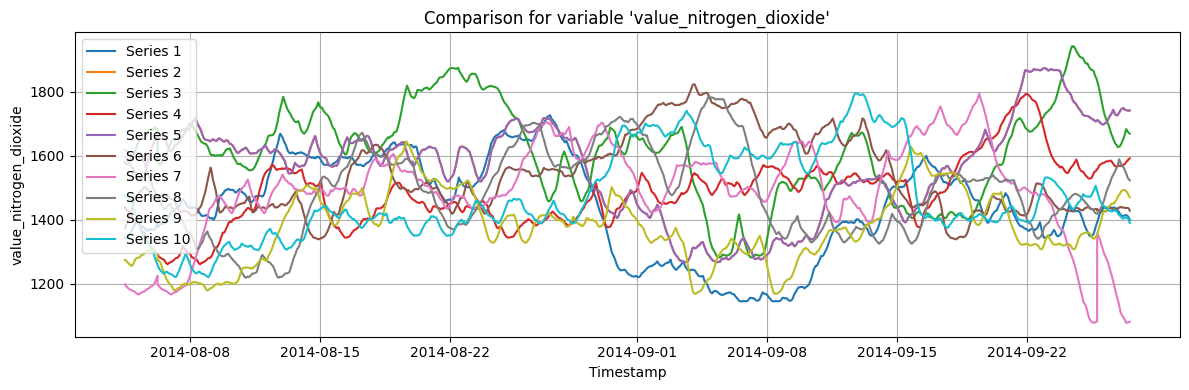

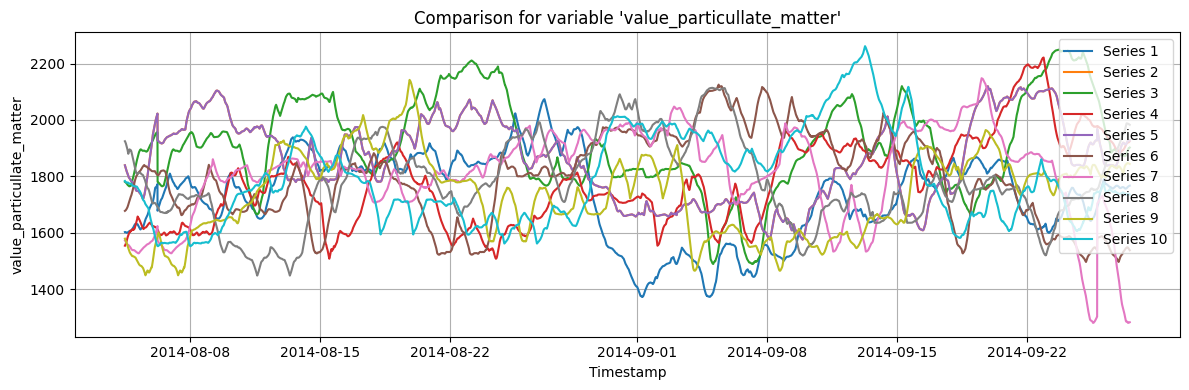

In [10]:
mx_profile[0].head()
ampiimts.plot_all_variables_multiple_dfs(mx_profile)

In [ ]:
pds_normalized = ampiimts.pre_processed(pds, sort_by_variables=True)
matrix_profiles = ampiimts.matrix_profile(pds_normalized)
ampiimts.plot_matrix_profiles_heatmap(matrix_profiles, 
                            time_index=matrix_profiles[0].index, 
                            capteur_labels=[f"Capteur {i+1}" for i in range(len(matrix_profiles))],
                            cmap="magma")  # Ou "viridis", "cubehelix", etc.


Best consensus window size(s): [(2016, '168h', np.float32(0.020001972), np.float64(0.0)), (864, '72h', np.float32(0.02235441), np.float64(0.0)), (576, '48h', np.float32(0.02542856), np.float64(0.0))]
Best consensus window size(s): [(864, '72h', np.float32(0.028703477), np.float64(0.0)), (2016, '168h', np.float32(0.033109393), np.float64(0.0)), (576, '48h', np.float32(0.034884136), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.031163292), np.float64(0.0)), (864, '72h', np.float32(0.037848298), np.float64(0.0)), (576, '48h', np.float32(0.039697435), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.01394072), np.float64(0.0)), (864, '72h', np.float32(0.027015828), np.float64(0.0)), (576, '48h', np.float32(0.028592216), np.float64(0.0))]
Best consensus window size(s): [(2016, '168h', np.float32(0.015898205), np.float64(0.0)), (864, '72h', np.float32(0.022959532), np.float64(0.0)), (576, '48h', np.float32(0.032978058), np.float64(

KeyboardInterrupt: 